In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):

        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg" or ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

ipshape=(224,224,3)
cancer_train = np.array(Dataset_loader('/content/drive/MyDrive/123/cancer_train',224)) #224
no_cancer_train = np.array(Dataset_loader('/content/drive/MyDrive/123/no_cancer_train',224))
cancer_test = np.array(Dataset_loader('/content/drive/MyDrive/123/cancer_test',224))
no_cancer_test = np.array(Dataset_loader('/content/drive/MyDrive/123/no_cancer_test',224))
cancer_train_label = np.zeros(len(cancer_train))
no_cancer_train_label = np.ones(len(no_cancer_train))
cancer_test_label = np.zeros(len(cancer_test))
no_cancer_test_label = np.ones(len(no_cancer_test))




100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


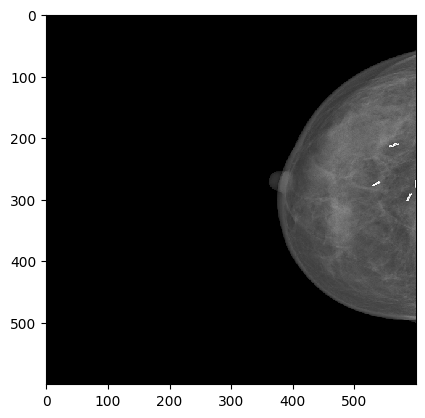

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(no_cancer_train[21], interpolation='nearest')
plt.show()

In [ ]:
#create labels
cancer_train_label = np.zeros(len(cancer_train))
no_cancer_train_label = np.ones(len(no_cancer_train))
cancer_test_label = np.zeros(len(cancer_test))
no_cancer_test_label = np.ones(len(no_cancer_test))

#merge data
X_train = np.concatenate((cancer_train, no_cancer_train), axis = 0)
Y_train = np.concatenate((cancer_train_label, no_cancer_train_label), axis = 0)
X_test = np.concatenate((cancer_test, no_cancer_test), axis = 0)
Y_test = np.concatenate((cancer_test_label, no_cancer_test_label), axis = 0)

#shuffle
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]


s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

#categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)




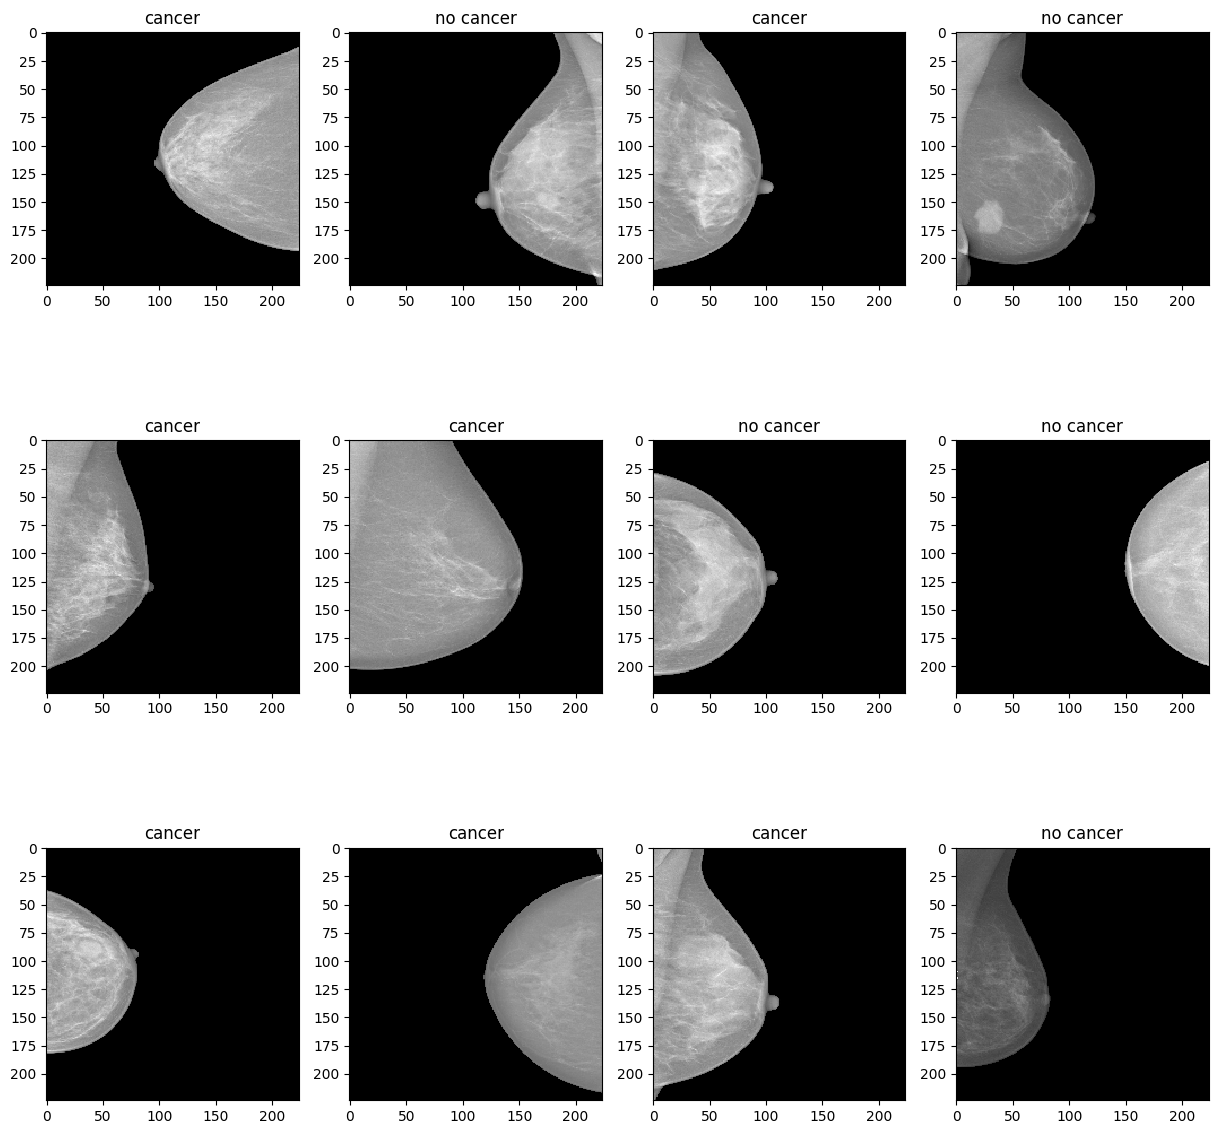

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('cancer')
    else:
        ax.title.set_text('no cancer')
    plt.imshow(x_train[i] , interpolation='nearest')
plt.show()

In [ ]:

BATCH_SIZE = 12

train_generator = ImageDataGenerator(
        zoom_range=1,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

val_generator = ImageDataGenerator(
        zoom_range=1,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )



In [ ]:
def build_model(backbone, learning_rate=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    model.summary()
    return model

In [ ]:
K.clear_session()
gc.collect()

37889

In [ ]:
def build_model(backbone,learning_rate=0.00001):

    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=ipshape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output from convolutional layers
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()
    return model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.applications import EfficientNetB7

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(600, 600, 3))

In [ ]:

from tensorflow.keras.applications import VGG19
base_model= tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(224,224,3))


model = build_model(base_model ,learning_rate=1e-4)
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
base_model = VGG19(   #DenseNet201
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_model= tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')


model = build_model(base_model,learning_rate=1e-4)
#model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/123/best/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
from matplotlib import pyplot as plt
for j in range(1,56):
  plt.imshow(x_train[j], interpolation='nearest')
  plt.show()
  print(y_train[j])



In [ ]:
history=model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch= x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=val_generator.flow(x_val, y_val, batch_size=BATCH_SIZE),
    #validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
8/7 [================================] - ETA: 0s - loss: 120.0173 - accuracy: 0.5222
Epoch 1: val_accuracy improved from -inf to 0.30435, saving model to /content/drive/MyDrive/123/best/weights.best.hdf5
7/7 [==============================] - 7s 517ms/step - loss: 120.0173 - accuracy: 0.5222 - val_loss: 1.9426 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 2/50
8/7 [================================] - ETA: 0s - loss: 0.9151 - accuracy: 0.5667
Epoch 2: val_accuracy improved from 0.30435 to 0.47826, saving model to /content/drive/MyDrive/123/best/weights.best.hdf5
7/7 [==============================] - 2s 237ms/step - loss: 0.9151 - accuracy: 0.5667 - val_loss: 0.7668 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 3/50
8/7 [================================] - ETA: 0s - loss: 0.7183 - accuracy: 0.5333
Epoch 3: val_accuracy did not improve from 0.47826
7/7 [==============================] - 2s 245ms/step - loss: 0.7183 - accuracy: 0.5333 - val_loss: 0.7750 - val_accuracy: 0.3478 - lr: 0.0

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.load_weights(filepath)

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['cancer', 'no_cancer']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

In [ ]:
import sklearn.metrics as metrics
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
f1=f1_score(Y_test, Y_pred_tta)

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
#@title
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "cancer"
    else:
        return "no_cancer"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()